#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * (옵션) 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * (옵션) 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

### (1) 경로 설정

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input, concatenate, SimpleRNN, LSTM, Flatten
from keras.callbacks import EarlyStopping
from keras.backend import clear_session
from keras.optimizers import Adam

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
#path = '/content/drive/MyDrive/project3/'
path = '/content/drive/MyDrive/Aivle_file/P9_project3/'

data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

# 불필요한 칼럼 삭제
data01_train.drop('subject', axis = 1, inplace = True)
data01_test.drop('subject', axis = 1, inplace = True)

#### 2) 기본 정보 조회

In [6]:
# 데이터의 행,열 개수 확인
print(data01_train.shape)
print(data01_test.shape)

(5881, 562)
(1471, 562)


In [7]:
data01_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [8]:
data01_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [9]:
data01_train['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [10]:
target = 'Activity'
x = data01_train.drop(target, axis = 1); x_col_name = x.columns
y = data01_train.loc[:, target]

print(x.shape)
print(y.shape)

(5881, 561)
(5881,)


### (2) 스케일링

* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [11]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [12]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

## **3. 기본 모델링**

* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy(F1-score) 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Base line 모델
  - Hidden Layer 없이 모델 설계
  - learning_rate=0.001, epochs=50

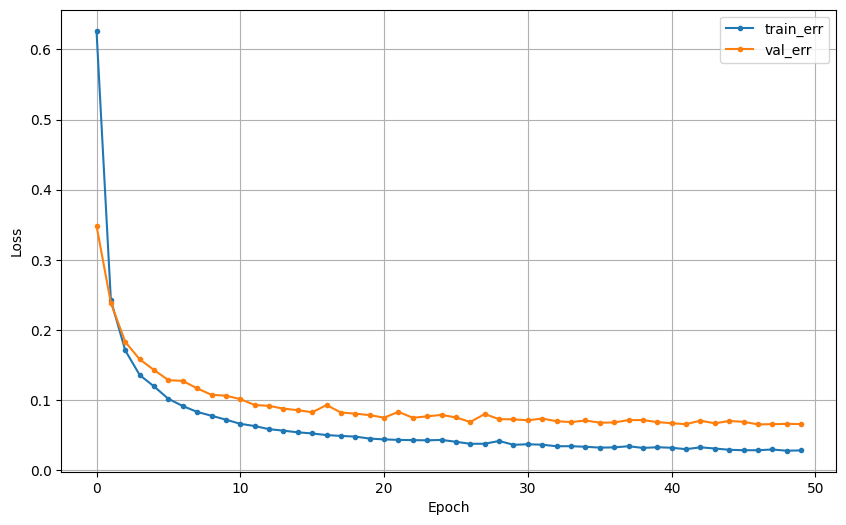

In [14]:
nfeatures = x_train.shape[1]
clear_session()

model1 = Sequential([Input(shape = (nfeatures,)),
                     Dense(6, activation = 'softmax')])

model1.compile(optimizer='adam',loss='sparse_categorical_crossentropy')
hist1=model1.fit(x_train,y_train,epochs=50,validation_split=0.2, verbose=0).history

dl_history_plot(hist1)

In [15]:
pred1 = model1.predict(x_val)
pred1 = np.argmax(pred1, axis = 1)

print('accuracy :',accuracy_score(y_val, pred1))
print('='*60)
print(confusion_matrix(y_val, pred1))
print('='*60)
print(classification_report(y_val, pred1, digits = 4, target_names = encoder.classes_))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
accuracy : 0.9821580288870009
[[231   0   0   0   0   0]
 [  0 196   4   0   0   0]
 [  0  15 211   0   0   0]
 [  0   0   0 196   0   2]
 [  0   0   0   0 145   0]
 [  0   0   0   0   0 177]]
                    precision    recall  f1-score   support

            LAYING     1.0000    1.0000    1.0000       231
           SITTING     0.9289    0.9800    0.9538       200
          STANDING     0.9814    0.9336    0.9569       226
           WALKING     1.0000    0.9899    0.9949       198
WALKING_DOWNSTAIRS     1.0000    1.0000    1.0000       145
  WALKING_UPSTAIRS     0.9888    1.0000    0.9944       177

          accuracy                         0.9822      1177
         macro avg     0.9832    0.9839    0.9833      1177
      weighted avg     0.9827    0.9822    0.9822      1177



* 반복 수행을 위한 코드

In [16]:
def train_model1(x_train, y_train, x_val, y_val):
    model1 = Sequential([Input(shape = (nfeatures,)), Dense(6, activation = 'softmax')])
    model1.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')
    model1.fit(x_train, y_train, epochs = 50, verbose=0)
    pred1 = model1.predict(x_val)
    pred1 = np.argmax(pred1, axis = 1)
    return accuracy_score(y_val, pred1)

In [17]:
result1 = []
for i in range(5):
    result1.append(train_model1(x_train, y_train, x_val, y_val))

print(result1)
print(np.mean(result1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[0.9787595581988106, 0.9830076465590484, 0.9770603228547153, 0.9779099405267629, 0.9796091758708582]
0.9792693288020391


### (2) 모델2 : 복잡한 모델 생성
  - 5개의 은닉층을 추가한 모델
  - learning_rate=0.001, epochs=50

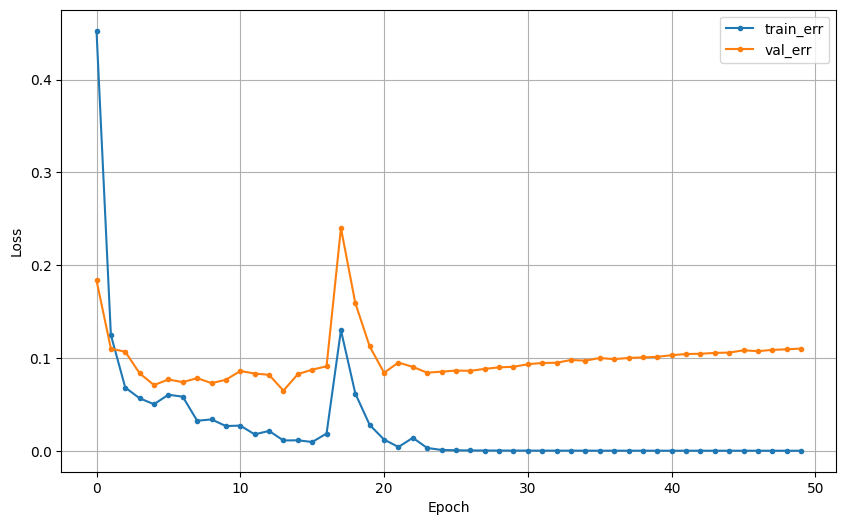

In [18]:
nfeatures = x_train.shape[1]
clear_session()

model2= Sequential([Input(shape = (nfeatures,)),
                 Dense(128, activation = 'relu'),
                 Dense(64, activation= 'relu'),
                 Dense(32, activation= 'relu'),
                 Dense(16, activation= 'relu'),
                 Dense(6, activation= 'softmax')])

model2.compile(optimizer=Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy')
hist2 = model2.fit(x_train,y_train,epochs=50,validation_split=0.2, verbose=0).history

dl_history_plot(hist2)

In [19]:
pred2 = model1.predict(x_val)
pred2 = np.argmax(pred2, axis = 1)

print('accuracy :',accuracy_score(y_val, pred2))
print('='*60)
print(confusion_matrix(y_val, pred2))
print('='*60)
print(classification_report(y_val, pred2, digits = 4, target_names = encoder.classes_))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
accuracy : 0.9821580288870009
[[231   0   0   0   0   0]
 [  0 196   4   0   0   0]
 [  0  15 211   0   0   0]
 [  0   0   0 196   0   2]
 [  0   0   0   0 145   0]
 [  0   0   0   0   0 177]]
                    precision    recall  f1-score   support

            LAYING     1.0000    1.0000    1.0000       231
           SITTING     0.9289    0.9800    0.9538       200
          STANDING     0.9814    0.9336    0.9569       226
           WALKING     1.0000    0.9899    0.9949       198
WALKING_DOWNSTAIRS     1.0000    1.0000    1.0000       145
  WALKING_UPSTAIRS     0.9888    1.0000    0.9944       177

          accuracy                         0.9822      1177
         macro avg     0.9832    0.9839    0.9833      1177
      weighted avg     0.9827    0.9822    0.9822      1177



* 반복 수행을 위한 코드

In [20]:
def train_model2(x_train, y_train, x_val, y_val):
    nfeatures = x_train.shape[1]
    clear_session()

    model2= Sequential([Input(shape = (nfeatures,)),
                    Dense(128, activation = 'relu'),
                    Dense(64, activation= 'relu'),
                    Dense(32, activation= 'relu'),
                    Dense(16, activation= 'relu'),
                    Dense(6, activation= 'softmax')])

    model2.compile(optimizer=Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy')
    model2.fit(x_train,y_train,epochs=50,validation_split=0.2, verbose=0)

    pred2 = model1.predict(x_val)
    pred2 = np.argmax(pred2, axis = 1)

    return accuracy_score(y_val, pred2)

In [21]:
result2 = []
for i in range(5):
    result2.append(train_model2(x_train, y_train, x_val, y_val))

print(result2)
print(np.mean(result2))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.9821580288870009, 0.9821580288870009, 0.9821580288870009, 0.9821580288870009, 0.9821580288870009]
0.982158028887001


### (3) 모델3
  - epochs = 100으로 조정
  - 과적합을 방지하기 위한 규제 기법 추가 : EarlyStopping, Dropout
  - 은닉층 3개로 축소

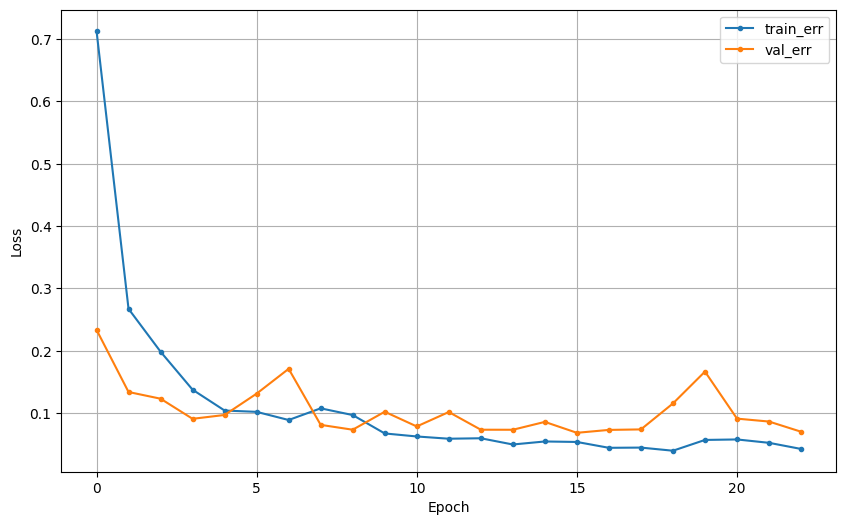

In [22]:
nfeatures = x_train.shape[1]
clear_session()

model3 = Sequential([Input(shape = (nfeatures, )),
                     Dense(128, activation = 'relu'),
                     Dropout(0.2),
                     Dense(64, activation = 'relu'),
                     Dropout(0.2),
                     Dense(32, activation = 'relu'),
                     Dropout(0.2),
                     Dense(6, activation = 'softmax')])
model3.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy')

min_de = 0.001
pat = 7

es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

hist3 = model3.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0, callbacks = [es]).history
dl_history_plot(hist3)

In [23]:
pred3 = model3.predict(x_val)
pred3 = np.argmax(pred3, axis = 1)

print('accuracy :',accuracy_score(y_val, pred3))
print('='*60)
print(confusion_matrix(y_val, pred3))
print('='*60)
print(classification_report(y_val, pred3, digits = 4, target_names = encoder.classes_))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
accuracy : 0.9847068819031436
[[231   0   0   0   0   0]
 [  0 191   9   0   0   0]
 [  0   6 220   0   0   0]
 [  0   0   0 196   1   1]
 [  0   0   0   0 145   0]
 [  0   0   0   0   1 176]]
                    precision    recall  f1-score   support

            LAYING     1.0000    1.0000    1.0000       231
           SITTING     0.9695    0.9550    0.9622       200
          STANDING     0.9607    0.9735    0.9670       226
           WALKING     1.0000    0.9899    0.9949       198
WALKING_DOWNSTAIRS     0.9864    1.0000    0.9932       145
  WALKING_UPSTAIRS     0.9944    0.9944    0.9944       177

          accuracy                         0.9847      1177
         macro avg     0.9852    0.9855    0.9853      1177
      weighted avg     0.9848    0.9847    0.9847      1177



* 반복 수행을 위한 코드

In [24]:
def train_model3(x_train, y_train, x_val, y_val):
    nfeatures = x_train.shape[1]
    clear_session()

    model3 = Sequential([Input(shape = (nfeatures, )),
                        Dense(128, activation = 'relu'),
                        Dropout(0.2),
                        Dense(64, activation = 'relu'),
                        Dropout(0.2),
                        Dense(32, activation = 'relu'),
                        Dropout(0.2),
                        Dense(6, activation = 'softmax')])
    model3.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy')

    min_de = 0.001
    pat = 7

    es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

    model3.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0, callbacks = [es])
    pred3 = model3.predict(x_val)
    pred3 = np.argmax(pred3, axis = 1)

    return accuracy_score(y_val, pred3)

In [25]:
result3 = []
for i in range(5):
    result3.append(train_model3(x_train, y_train, x_val, y_val))

print(result3)
print(np.mean(result3))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[0.9770603228547153, 0.9711129991503823, 0.9728122344944775, 0.9753610875106202, 0.9855564995751912]
0.9763806287170773


### (4) 모델4 : x,y,z 컬럼 나눠 다중 입력
  - input layer 5개
  - hidden layer_1 : Dense 32, 32, 32, 16, 16 (입력층 순서대로)
  - hidden layer_2 : Dense(8) 추가 히든레이어
  - epochs = 100으로 조정
  - learning_rate = 0.001, epochs = 60

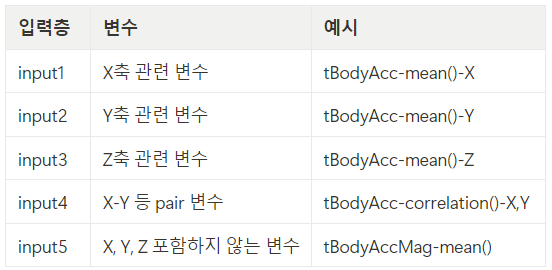

In [26]:
x_train = pd.DataFrame(x_train, columns = x_col_name)
x_val = pd.DataFrame(x_val, columns = x_col_name)

In [27]:
# 전처리
result = []
result.append(x_train.columns[x_train.columns.str.contains('X')].tolist()) # X축 관련 변수
result.append(x_train.columns[x_train.columns.str.contains('Y')].tolist()) # Y축 관련 변수
result.append(x_train.columns[x_train.columns.str.contains('Z')].tolist()) # Z축 관련 변수

unique_elements, counts = np.unique(np.array(result).flatten(), return_counts = True)
duplicates = unique_elements[counts > 1].tolist() # X-Y 등 두 축이 포함된 변수 -> pair 변수 (중복 변수)

x_columns_with_X = x_train.columns[x_train.columns.str.contains('X')]
col_X = x_columns_with_X[~x_columns_with_X.isin(duplicates)] # X축 관련 변수(중복 제거)

x_columns_with_Y = x_train.columns[x_train.columns.str.contains('Y')]
col_Y = x_columns_with_Y[~x_columns_with_Y.isin(duplicates)] # Y축 관련 변수(중복 제거)

x_columns_with_Z = x_train.columns[x_train.columns.str.contains('Z')]
col_Z = x_columns_with_Z[~x_columns_with_Z.isin(duplicates)] # Z축 관련 변수(중복 제거)

x_columns_with_XYZ = x_train.columns[x_train.columns.str.contains('X|Y|Z', regex = True)]
col_None = x_train.columns[~x_train.columns.isin(x_columns_with_XYZ)] # X, Y, Z 모두 포함 x

In [28]:
print(col_X.shape[0]) # X축 변수
print(col_Y.shape[0]) # Y축 변수
print(col_Z.shape[0]) # Z축 변수
print(len(duplicates)) # (X, Y) pair 변수
print(col_None.shape[0]) # X, Y, Z 포함하지 않는 변수
print('------')
print(x_train.shape[1]) # 전체 변수

97
97
97
15
255
------
561


In [29]:
# 입력1 : X축 변수
x_train1 = x_train[col_X]
x_val1 = x_val[col_X]

# 입력2 : Y축 변수
x_train2 = x_train[col_Y]
x_val2 = x_val[col_Y]

# 입력3 : Z축 변수
x_train3 = x_train[col_Z]
x_val3 = x_val[col_Z]

# 입력4 : X-Y, Y-Z, X-Z pair 변수
x_train4 = x_train[duplicates]
x_val4 = x_val[duplicates]

# 입력5 : X, Y, Z 제외 변수
x_train5 = x_train[col_None]
x_val5 = x_val[col_None]

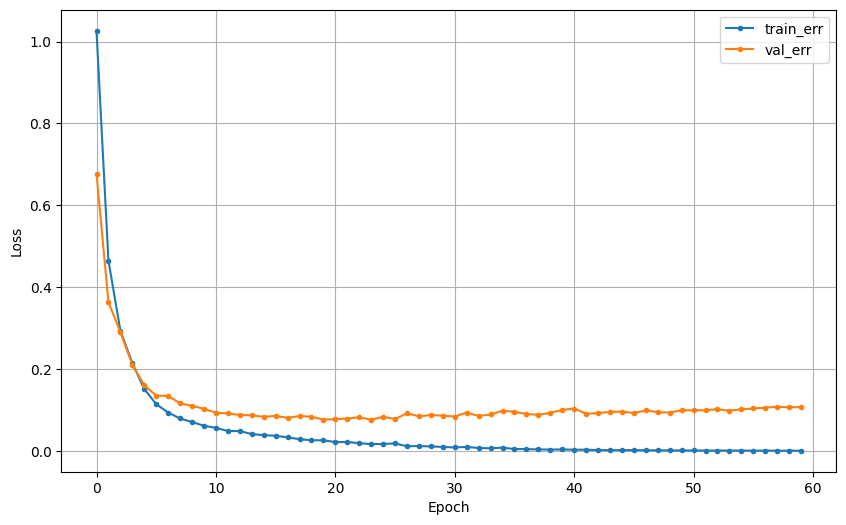

In [30]:
# 다중 입력 모델링
nfeatures1 = x_train1.shape[1]
nfeatures2 = x_train2.shape[1]
nfeatures3 = x_train3.shape[1]
nfeatures4 = x_train4.shape[1]
nfeatures5 = x_train5.shape[1]

# 모델 구성
input_1 = Input(shape=(nfeatures1,), name='input_1')
input_2 = Input(shape=(nfeatures2,), name='input_2')
input_3 = Input(shape=(nfeatures3,), name='input_3')
input_4 = Input(shape=(nfeatures4,), name='input_4')
input_5 = Input(shape=(nfeatures5,), name='input_5')

hl1_1 = Dense(32, activation='relu')(input_1)
hl1_2 = Dense(32, activation='relu')(input_2)
hl1_3 = Dense(32, activation='relu')(input_3)
hl1_4 = Dense(16, activation='relu')(input_4)
hl1_5 = Dense(16, activation='relu')(input_5)

cbl = concatenate([hl1_1, hl1_2, hl1_3, hl1_4, hl1_5])

# 추가 히든레이어
hl2 = Dense(4, activation='relu')(cbl)

# 출력 레이어
output = Dense(6, activation='softmax')(hl2)

# 모델 선언
model4 = Model(inputs=[input_1, input_2, input_3, input_4, input_5], outputs=output)

# 컴파일
model4.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy')

hist4 = model4.fit([x_train1, x_train2, x_train3, x_train4, x_train5], y_train,
                  epochs = 60, validation_split = .2, verbose = 0).history
dl_history_plot(hist4)

In [31]:
pred4 = model4.predict([x_val1, x_val2, x_val3, x_val4, x_val5])
pred4 = np.argmax(pred4, axis = 1)

print('accuracy :',accuracy_score(y_val, pred4))
print('='*60)
print(confusion_matrix(y_val, pred4))
print('='*60)
print(classification_report(y_val, pred4, digits = 4, target_names = encoder.classes_))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
accuracy : 0.9864061172472387
[[231   0   0   0   0   0]
 [  0 196   4   0   0   0]
 [  0   8 218   0   0   0]
 [  0   0   0 195   0   3]
 [  0   0   0   0 145   0]
 [  0   1   0   0   0 176]]
                    precision    recall  f1-score   support

            LAYING     1.0000    1.0000    1.0000       231
           SITTING     0.9561    0.9800    0.9679       200
          STANDING     0.9820    0.9646    0.9732       226
           WALKING     1.0000    0.9848    0.9924       198
WALKING_DOWNSTAIRS     1.0000    1.0000    1.0000       145
  WALKING_UPSTAIRS     0.9832    0.9944    0.9888       177

          accuracy                         0.9864      1177
         macro avg     0.9869    0.9873    0.9870      1177
      weighted avg     0.9866    0.9864    0.9864      1177



* 반복 수행을 위한 코드

In [32]:
def train_model4(x_train, y_train, x_val, y_val):
    # 모델 구성
    input_1 = Input(shape=(nfeatures1,), name='input_1')
    input_2 = Input(shape=(nfeatures2,), name='input_2')
    input_3 = Input(shape=(nfeatures3,), name='input_3')
    input_4 = Input(shape=(nfeatures4,), name='input_4')
    input_5 = Input(shape=(nfeatures5,), name='input_5')

    hl1_1 = Dense(32, activation='relu')(input_1)
    hl1_2 = Dense(32, activation='relu')(input_2)
    hl1_3 = Dense(32, activation='relu')(input_3)
    hl1_4 = Dense(16, activation='relu')(input_4)
    hl1_5 = Dense(16, activation='relu')(input_5)

    cbl = concatenate([hl1_1, hl1_2, hl1_3, hl1_4, hl1_5])

    # 추가 히든레이어
    hl2 = Dense(4, activation='relu')(cbl)

    # 출력 레이어
    output = Dense(6, activation='softmax')(hl2)

    # 모델 선언
    model4 = Model(inputs=[input_1, input_2, input_3, input_4, input_5], outputs=output)

    # 컴파일
    model4.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy')

    model4.fit([x_train1, x_train2, x_train3, x_train4, x_train5], y_train,
                      epochs = 60, validation_split = .2, verbose = 0)

    pred4 = model4.predict([x_val1, x_val2, x_val3, x_val4, x_val5])
    pred4 = np.argmax(pred4, axis = 1)

    return accuracy_score(y_val, pred4)

In [33]:
result4 = []
for i in range(5):
    result4.append(train_model4(x_train, y_train, x_val, y_val))

print(result4)
print(np.mean(result4))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[0.9762107051826678, 0.9855564995751912, 0.9813084112149533, 0.9787595581988106, 0.9830076465590484]
0.9809685641461343


## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [52]:
newdata = data01_test

# x, y 분할
new_x = newdata.drop(['Activity'], axis = 1)
new_y = newdata.Activity

# x : 스케일링 적용
new_x = scaler.transform(new_x)

# y : 정수인코딩 적용
new_y = encoder.transform(new_y)

In [55]:
# test 데이터에 대한 성능 측정
result = {}
models = [model1, model2, model3, model4]
for i, model in enumerate(models):
  if i != 3:
    pred = model.predict(new_x)
    pred = np.argmax(pred, axis = 1)

  else:
    # model4 : 다른 전처리
    new_x = pd.DataFrame(new_x, columns = x_col_name)
    new_x1 = new_x[col_X]
    new_x2 = new_x[col_Y]
    new_x3 = new_x[col_Z]
    new_x4 = new_x[duplicates]
    new_x5 = new_x[col_None]
    pred = model.predict([new_x1, new_x2, new_x3, new_x4, new_x5])
    pred = np.argmax(pred, axis = 1)
  result[f'model{i+1}'] = accuracy_score(new_y, pred)
  print(f'model{i+1}, accuracy : {accuracy_score(new_y, pred)}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
model1, accuracy : 0.9755268524813052
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
model2, accuracy : 0.9741672331747111
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
model3, accuracy : 0.9762066621346023
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
model4, accuracy : 0.9836845683208701


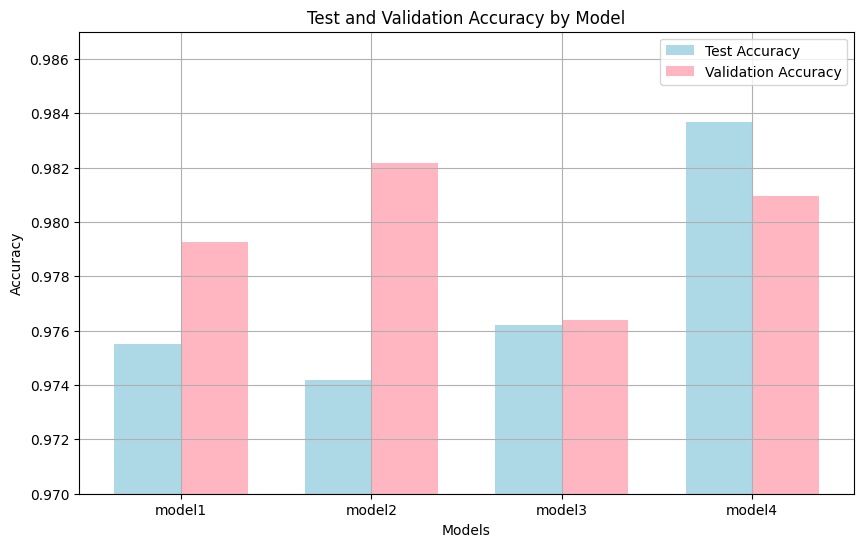

In [56]:
# 성능비교 막대그래프
result_df = pd.DataFrame(result.values(), columns = ['test_accuracy'], index = result.keys())
result_df['val_accuracy'] = [np.mean(result1), np.mean(result2), np.mean(result3), np.mean(result4)]

# 막대의 위치
x = np.arange(len(result_df.index))

# 막대의 폭
width = 0.35

# 막대그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))

# 테스트 정확도 막대
ax.bar(x - width/2,result_df['test_accuracy'], width, label='Test Accuracy', color='lightblue')

# 검증 정확도 막대
ax.bar(x + width/2, result_df['val_accuracy'], width, label='Validation Accuracy', color='lightpink')

# 그래프 꾸미기
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Test and Validation Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(result_df.index)
ax.legend()

plt.ylim(0.97, 0.987)
plt.grid(True)

# 그래프 보여주기
plt.show()

# 추가

## 5.RNN

#### RNN 전처리

In [34]:
x.shape, y.shape

((5881, 561), (5881,))

In [35]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

In [36]:
x2,y2=temporalize(x,y,4)
x2.shape,y2.shape

((5878, 4, 561), (5878,))

In [37]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 0.2, shuffle = False)

In [38]:
# 잘 나뉘어 졌는지 확인
x_train.shape, y_train.shape

((4702, 4, 561), (4702,))

In [39]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

timesteps,nfeatures

(4, 561)

#### 모델

In [40]:
# 모델
clear_session()

model5=Sequential([Input(shape=(timesteps,nfeatures)),
                  SimpleRNN(16,return_sequences=True),
                  SimpleRNN(8),
                  Flatten(),
                  Dense(10,activation='relu'),
                  Dense(6,activation='softmax')])

model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 4, 16)               │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,604 (37.52 KB)

 Trainable params: 9,604 (37.52 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model5.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy')

hist5=model5.fit(x_train,y_train,epochs=20,validation_split=.2,verbose=0).history

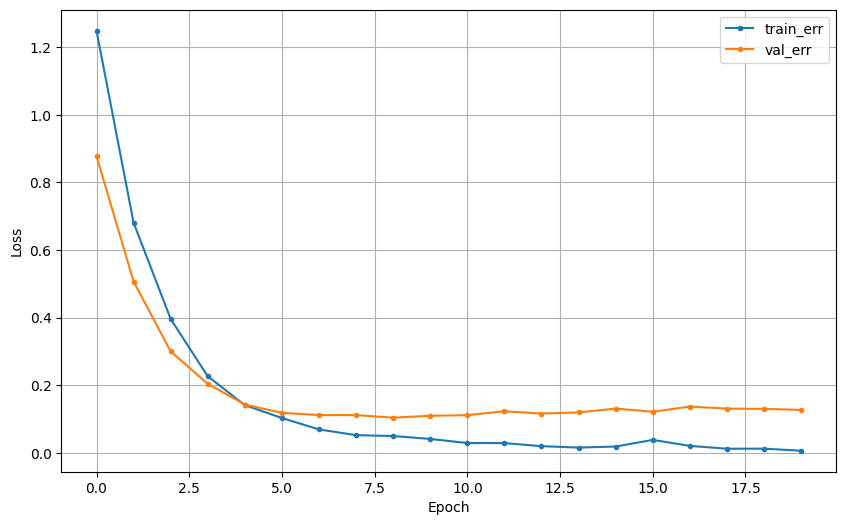

In [42]:
#학습곡선 그리기
dl_history_plot(hist5)

#### 예측 및 결과

In [57]:
#예측 및 결과
pred5=model5.predict(x_val)
pred5=np.argmax(pred5,axis=1)

print('accuracy :',accuracy_score(y_val, pred5))
print(classification_report(y_val, pred5))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
accuracy : 0.9719387755102041
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       0.95      0.92      0.93       205
           2       0.93      0.95      0.94       220
           3       0.99      1.00      0.99       189
           4       0.99      0.99      0.99       153
           5       0.98      0.98      0.98       176

    accuracy                           0.97      1176
   macro avg       0.97      0.97      0.97      1176
weighted avg       0.97      0.97      0.97      1176



## 6.LSTM

In [46]:
clear_session()

model6 = Sequential([Input(shape = (timesteps, nfeatures)),
                    LSTM(8, return_sequences = True),
                    LSTM(8),
                    Dense(6,activation='softmax')])

model6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4, 8)                │          18,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,838 (73.59 KB)

 Trainable params: 18,838 (73.59 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model6.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy')

hist6=model6.fit(x_train,y_train,epochs=20,validation_split=.2,verbose=0).history

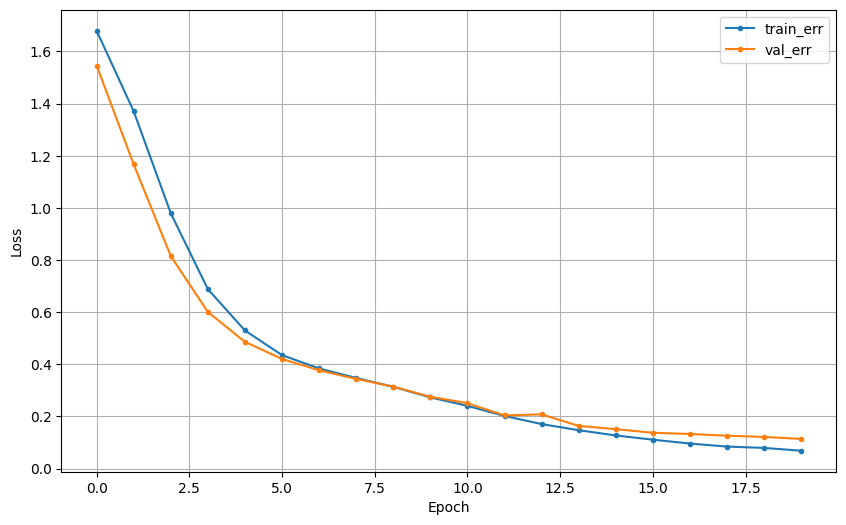

In [48]:
dl_history_plot(hist6)

In [49]:
pred6=model6.predict(x_val)
pred6=np.argmax(pred6,axis=1)

print(classification_report(y_val, pred6))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       0.96      0.92      0.94       205
           2       0.93      0.97      0.95       220
           3       0.96      0.99      0.98       189
           4       1.00      1.00      1.00       153
           5       0.99      0.96      0.98       176

    accuracy                           0.97      1176
   macro avg       0.97      0.97      0.97      1176
weighted avg       0.97      0.97      0.97      1176

